In [2]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
from jax import vmap

## Helpers

In [5]:
def make_grid(x_range, y_range, n_points):
    aspect_ratio = (y_range[1] - y_range[0]) / (x_range[1] - x_range[0])
    xx, yy = jnp.meshgrid(jnp.linspace(*x_range, n_points), jnp.linspace(*y_range, int(n_points * aspect_ratio)))
    return xx, yy


def sample_func(func, x_range, y_range, n_points):
    xx, yy = make_grid(x_range, y_range, n_points)
    func = vmap(vmap(func, (0, 0), 0), (0, 0), 0)
    out = func(xx, yy)
    return xx, yy, out


def sample_trajectory(dynamics_func, s0, n_steps, step_size):
    s0 = jnp.array(s0)
    dynamics_func = vmap(dynamics_func, (0, 0), 0)
    x, y = s0
    traj_x, traj_y = [x], [y]
    speeds = []
    for _ in range(n_steps):
        delta_x, delta_y = dynamics_func(x, y)
        x += step_size * delta_x
        y += step_size * delta_y
        traj_x.append(x)
        traj_y.append(y)
        speeds.append(jnp.sqrt(delta_x**2 + delta_y**2))
    trajectories = jnp.stack([jnp.stack(traj_x), jnp.stack(traj_y)], axis=-1)
    trajectories = trajectories.transpose(1, 0, 2)
    speeds = jnp.stack(speeds).transpose(1, 0)
    return trajectories, speeds


def get_basins_of_attraction(dynamics_func, x_range, y_range, n_points, n_steps, step_size):
    xx, yy = make_grid(x_range, y_range, n_points)
    _, speeds = sample_trajectory(dynamics_func, (xx.flatten(), yy.flatten()), 
                                  n_steps, step_size)
    final_speeds = speeds[:, -1]
    final_speeds = final_speeds.reshape(xx.shape)
    is_basin = final_speeds < 1e-5
    return xx, yy, is_basin


def plot_vector_field(ax,
                      dynamics_func, 
                      x_range=[-2, 2], 
                      y_range=[-2, 2], 
                      n_points=10,
                      **kwargs):
    xx_p, yy_p, (xx_p_grad, yy_p_grad) = sample_func(dynamics_func, 
                                                     x_range=x_range, 
                                                     y_range=y_range, 
                                                     n_points=n_points)
    ax.quiver(xx_p, yy_p, xx_p_grad, yy_p_grad, angles='xy', scale_units='xy', color='gray', **kwargs)


def plot_trajectories(ax,
                      dynamics_func,
                      s0,
                      n_steps=50, 
                      step_size=0.1,
                      trajectory_clip=None,
                      final_marker=False,
                      **kwargs):
    trajectories, _ = sample_trajectory(dynamics_func, 
                                        s0=s0, 
                                        n_steps=n_steps, 
                                        step_size=step_size)
    for i, traj in enumerate(trajectories):
        if trajectory_clip is not None and trajectory_clip[i] is not None:
            traj = traj[:trajectory_clip[i]]
        ax.scatter(traj[:-1, 0][::-1], traj[:-1, 1][::-1], 
                   color=sns.color_palette()[0],
                   linewidth=0,
                   alpha=0.9,
                   s=10 * np.linspace(0.15, 1, num=len(traj) - 1),
                   **kwargs)
        if  isinstance(final_marker, bool) and final_marker or \
            not isinstance(final_marker, bool) and final_marker[i]:
            ax.scatter(traj[-1, 0], traj[-1, 1], color='black', s=30, marker='x')
            
            
def plot_trajectory_field(ax,
                          dynamics_func,
                          x_range=[-2, 2], 
                          y_range=[-2, 2], 
                          n_points=10,
                          n_steps=10, 
                          step_size=0.05,
                          **kwargs):
    xx, yy = make_grid(x_range, y_range, n_points)
    x, y = xx.flatten(), yy.flatten()
    s0 = jnp.stack([x, y], axis=0)
    trajectories, _ = sample_trajectory(dynamics_func,
                                        s0=s0,
                                        n_steps=n_steps,
                                        step_size=step_size)
    for traj in trajectories:
        ax.plot(traj[:, 0], traj[:, 1], color='gray', linewidth=0.1, **kwargs)
        
        
def plot_basins_of_attraction(ax,
                              dynamics_func,
                              x_range=[-2, 2], 
                              y_range=[-2, 2], 
                              n_points=1000,
                              n_steps=100,
                              step_size=1):
    xx_b, yy_b, is_basin = get_basins_of_attraction(dynamics_func, 
                                                    x_range=x_range, 
                                                    y_range=y_range,
                                                    n_points=n_points, 
                                                    n_steps=n_steps, 
                                                    step_size=step_size)
    ax.contourf(xx_b, yy_b, is_basin, levels=[0.5, 1], colors='black', alpha=0.1)
    ax.contour(xx_b, yy_b, is_basin, colors='black', linewidths=0.2)

## Q1

In [29]:
def q1_dynamics(delta, mu):
    return lambda x, y: (y, -delta * y - mu * x - x**2)

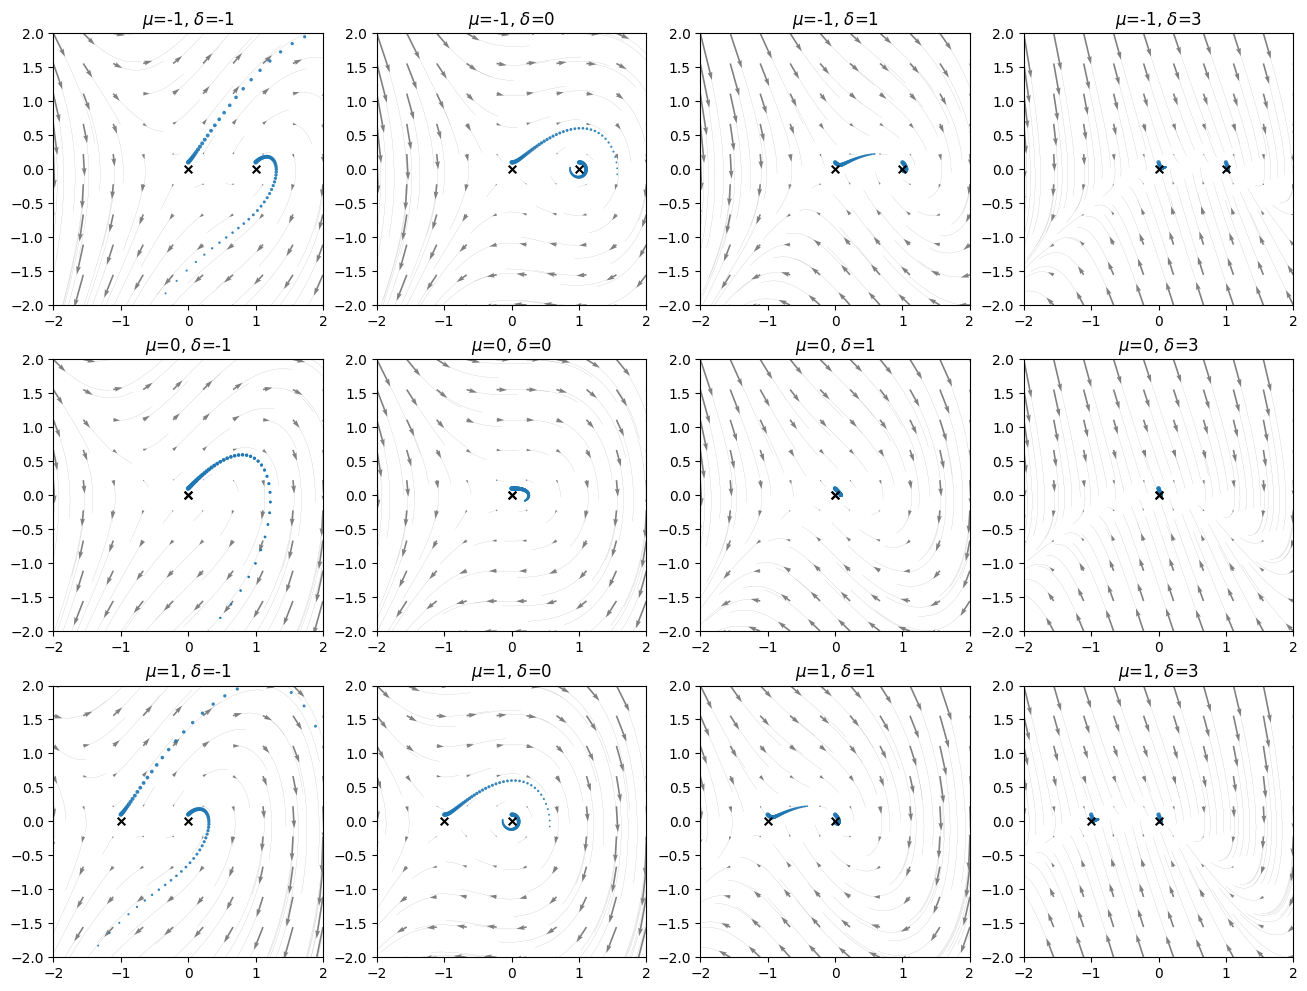

In [34]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))

for i, mu in enumerate([-1, 0, 1]):
       for j, delta in enumerate([-1, 0, 1, 3]):
              dynamics = q1_dynamics(delta, mu)
              plot_trajectory_field(axs[i, j], dynamics)
              plot_vector_field(axs[i, j], dynamics)
              plot_trajectories(axs[i, j], dynamics, 
                                s0=[[0, -mu], [0.1, 0.1]])
              
              # Annotate fixed points
              axs[i, j].scatter([0, -mu], [0, 0], color='black', s=30, marker='x')

              axs[i, j].set(xlim=(-2, 2), ylim=(-2, 2))
              axs[i, j].set_title(f'$\mu$={mu}, $\delta$={delta}')

plt.show()

## Q8

In [4]:
def q8_dynamics(delta, mu):
    return lambda x, y: (y, -delta * y - mu * x)

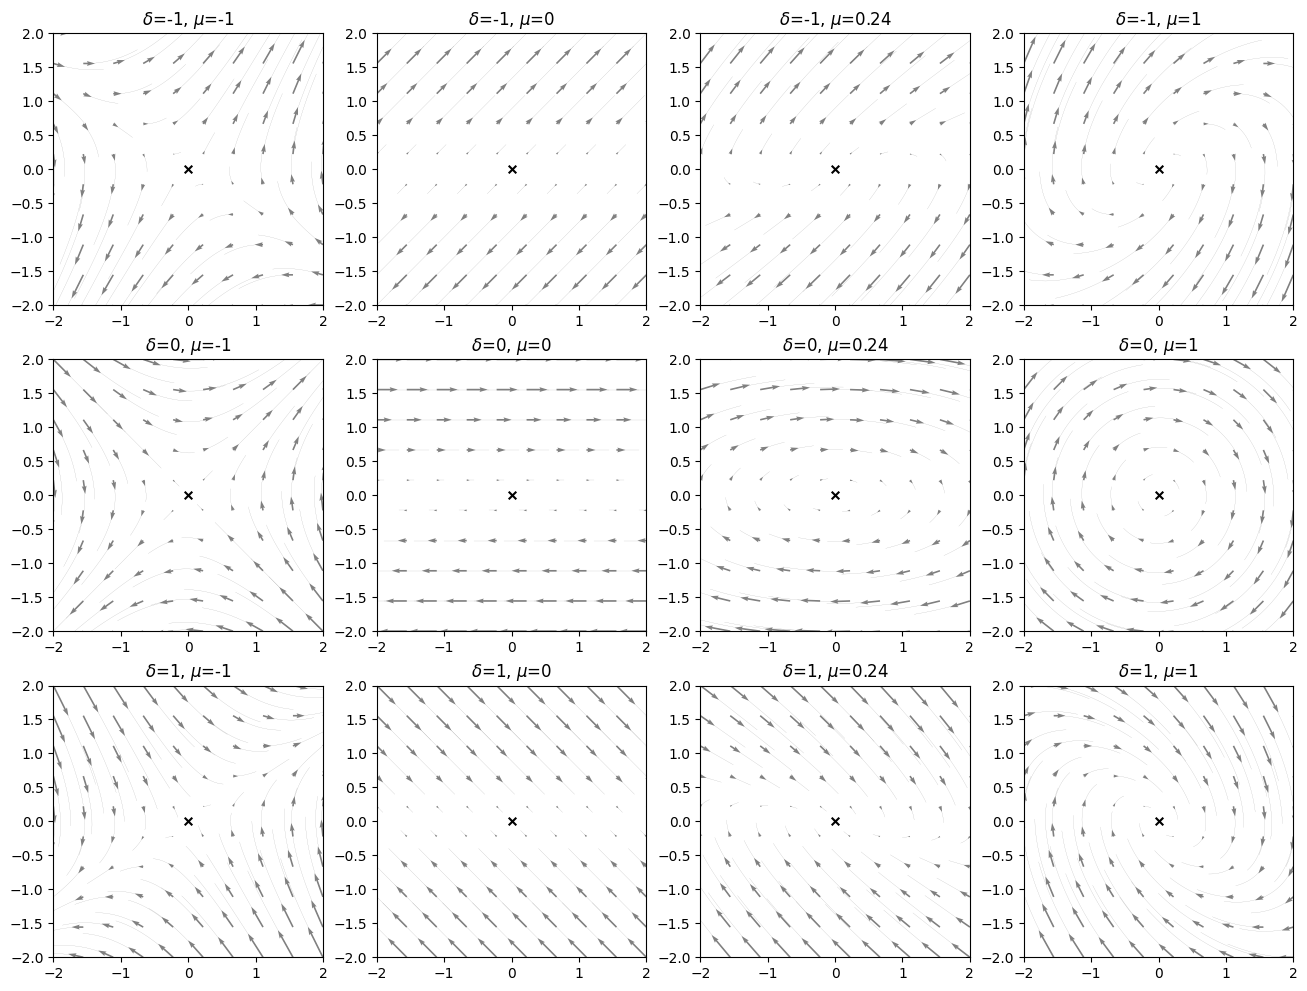

In [14]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))

for j, mu in enumerate([-1, 0, 0.24, 1]):
       for i, delta in enumerate([-1, 0, 1]):
              dynamics = q8_dynamics(delta, mu)
              plot_trajectory_field(axs[i, j], dynamics)
              plot_vector_field(axs[i, j], dynamics)
              
              # Annotate fixed points
              axs[i, j].scatter([0], [0], color='black', s=30, marker='x')

              axs[i, j].set(xlim=(-2, 2), ylim=(-2, 2))
              axs[i, j].set_title(f'$\delta$={delta}, $\mu$={mu}')

plt.show()